In [1]:
import sys
sys.path.append('../')
sys.path.append('../rlkit_master/')

import pickle
from rlkit_master.rlkit.samplers.rollout_functions import rollout
from rlkit_master.rlkit.envs.wrappers import NormalizedBoxEnv
import torch
import seaborn as sns
from gym.envs.mujoco import HalfCheetahEnv

from bokeh.plotting import figure, show, output_file
from bokeh.plotting import output_notebook
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.client import push_session, pull_session

from bokeh.io import curdoc
from bokeh.layouts import row, column
from bokeh.models import CustomJS, Slider,TextInput
from bokeh.plotting import figure, show, ColumnDataSource

output_notebook()

import matplotlib.pyplot as plt
# import seaborn as sns

from scipy.fftpack import fft, fftfreq, fftshift
from scipy.stats import entropy
from skimage import util
import numpy as np
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import mean_squared_error
from math import sqrt

Loading BokehJS ...

In [2]:
eval_env = NormalizedBoxEnv(HalfCheetahEnv())
itr = 2990
exp_name = 'name-of-experiment_2019_11_22_14_30_29_0000--s-0'
agent = torch.load(f'../rlkit_master/data/name-of-experiment/{exp_name}/itr_{itr}.pkl')

/Users/mariakulikovskaya/.local/share/virtualenvs/Fourier_RL-018KUzE7/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
eval_env.observation_space.shape[0]


17

In [4]:
agent = agent['trainer/policy']
rollout_dict = rollout(
        env = eval_env ,
        agent = agent,
        max_path_length=1000,
        render=False,
        render_kwargs=None,
)

In [5]:
len(rollout_dict['rewards'])

1000

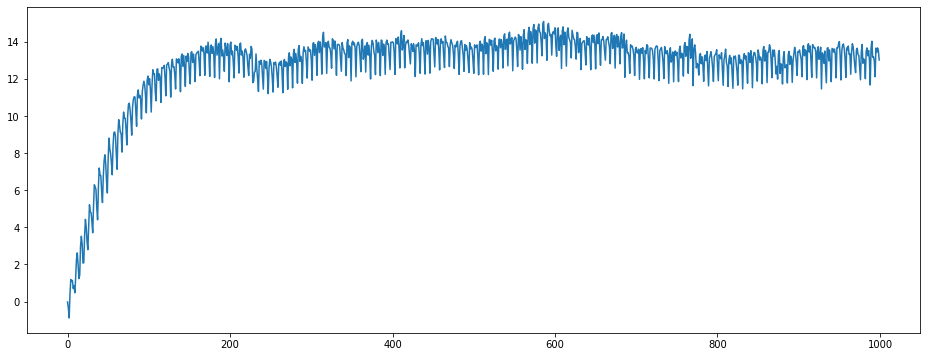

In [6]:
# plot rewards
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=[i for i in range(1000)], y=rollout_dict['rewards'][:,0][:1000])
plt.show()

In [7]:
rollout_dict['rewards'].sum()

12653.17946194867

In [8]:
def get_reward_from_epoch(epoch_num):
    agent = torch.load(f'../rlkit_master/data/name-of-experiment/{exp_name}/itr_{epoch_num}.pkl')
    agent = agent['trainer/policy']

    rollout_dict = rollout(
    env = eval_env ,
    agent = agent,
    max_path_length=1000,
    render=False,
    render_kwargs=None,
        )
    
#     print(np.abs(spectrum).mean(axis = 1))
#     print(spectrum.mean(axis = 1))
#     spectrum = np.abs(spectrum)


#     spectrum_shift = np.fft.fftshift(np.abs(y))
#     print(spectrum_shift)
    return rollout_dict['rewards']

In [10]:
max_steps = 2990
y_dict ={}
for epoch in range(0,max_steps,10):
    y_dict[f'{epoch}'] = get_reward_from_epoch(epoch)
y_dict["y"] = y_dict['0']

y_dict['x'] = np.arange(len(y_dict["y"]))

source = ColumnDataSource(data= y_dict)

plot = figure(y_range=(-1, 18), plot_width=400, plot_height=400)

plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

epoch_slider = Slider(start=0, end=max_steps, value=0, step=10, title="Epoch")
# act_num_slider = Slider(start=0, end=5, value=1, step=1, title="Act_num")
# phase_slider = Slider(start=0, end=6.4, value=0, step=.1, title="Phase")
# offset_slider = Slider(start=-5, end=5, value=0, step=.1, title="Offset")

callback = CustomJS(args=dict(source=source, epoch=epoch_slider),
                    code="""
    const data = source.data;
    const E = epoch.value;
    const x = data['x'];
    const y = data[E.toString()];
    data['y'] = y;
    
    
    source.change.emit();
""")

epoch_slider.js_on_change('value', callback)
# phase_slider.js_on_change('value', callback)
# offset_slider.js_on_change('value', callback)

layout = row(
    plot,
    column(epoch_slider),
)

# output_file("slider.html", title="slider.py example")

show(layout)

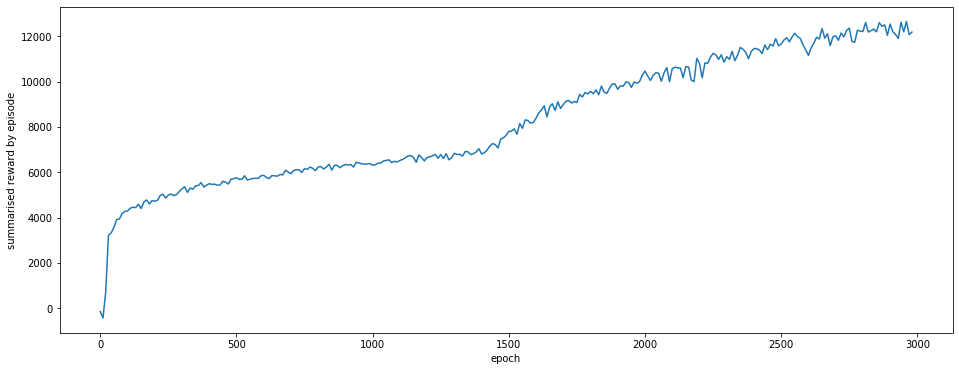

In [21]:
epoch_reward_sum = []
for epoch in range(0,max_steps,10):
    epoch_reward_sum.append(np.sum( y_dict[f'{epoch}']))
    
    
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=[i*10 for i in range(len(epoch_reward_sum))], y=epoch_reward_sum)
plt.xlabel('epoch')
plt.ylabel('summarised reward by episode')
plt.show()

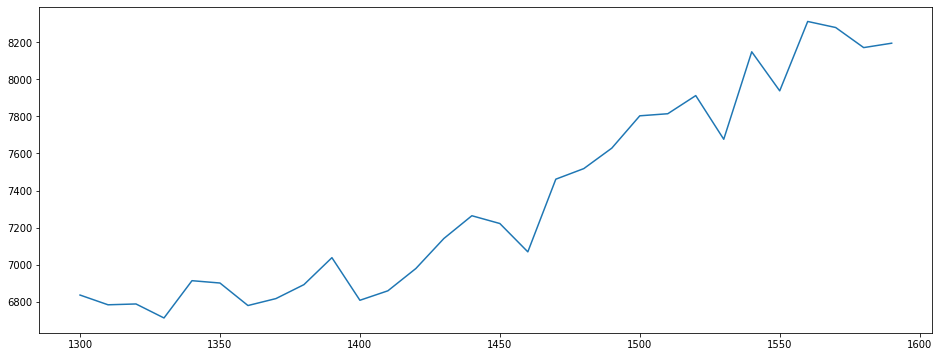

In [13]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=[i*10 for i in range(len(epoch_reward_sum))][130:160], y=epoch_reward_sum[130:160])
plt.show()